In [1]:
from transformers import GPT2LMHeadModel

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

# weight and postional embeddings size,
# 50257 token size vocab with embedding size of 768, 1024 is the max sequence length each position represented by embedding size of 768.
# transformer.wte.weight torch.Size([50257, 768])
# transformer.wpe.weight torch.Size([1024, 768])

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [4]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

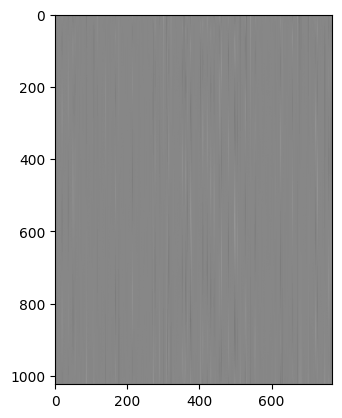

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

# each position is a row below and has a certain representation.

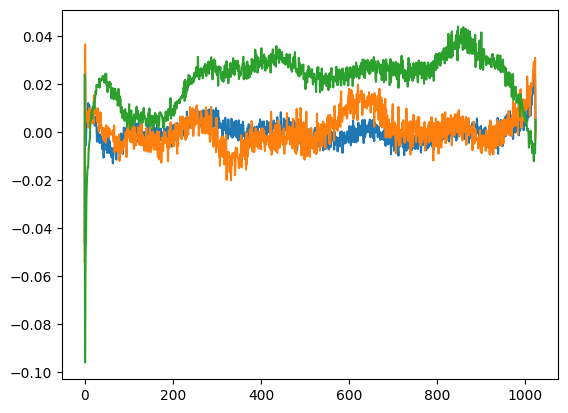

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

# grabbed 3 random columns
# the channel information e.g. green below is not fully trained, it looks bit noisy and the poistions below 200 and above 1000 are dropped.
# the more this model was trained, the smoother the channels would be.
# but its not bad, looks bit sinusoidal in nature.

# In transformer paper these positional embeddings are fixed to sines and cosines, whereas in above gpt2 model, these were trained.

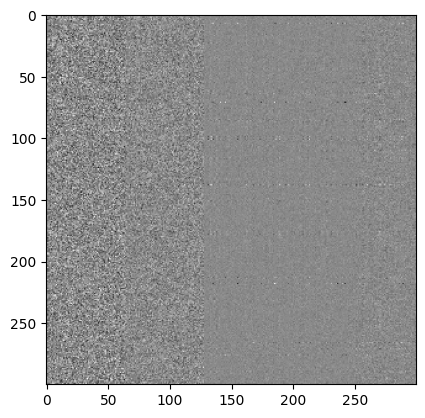

In [7]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

In [8]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I am a Language Model,", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I am a Language Model, but what I do in that role is different than everything else. I'm a model of success, and I"},
 {'generated_text': 'Hello, I am a Language Model, this is not the best and therefore there are exceptions. Some are not as straightforward as others so here is my'},
 {'generated_text': 'Hello, I am a Language Model, and I will guide you in this journey!\n\nOne of the things we learned is to create templates and'},
 {'generated_text': 'Hello, I am a Language Model, not a Programming Language, and you have heard my story.\n\nI was a huge fan of the program'},
 {'generated_text': "Hello, I am a Language Model, I live in Seattle and in New York. I've been in a field that has a lot of diversity."}]

In [12]:
# we will use shakespeare text for training
# compression ratio for gpt2 tokenizer is 3:1, so for 1000 characters, we will get 300 tokens

with open('/Users/manpreet.singh/git/gpt/dataset/input.txt', 'r') as file:
    text = file.read()
data = text[:1000]
print(data[:100])

import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [14]:
# input tokens also need to be converted to tensor of shape (B, T) where B is the batch size and T is the sequence length
# here we create input x of size (B,T) where B=4 and T=6
# we will also create a label (output) y of size (B,T) where B=4 and T=6

import torch
buf = torch.tensor(tokens[:24 + 1]) # 24 tokens + 1 for the last token
x = buf[:-1].view(4, 6) # till second last token
y = buf[1:].view(4, 6) # from second token till last token
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [17]:
# small bug to be fixed, the wte and linear layer at the end share same wieghts or embeddings
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

# compare each element of the weights
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

# points to the same memory location
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.ln_f.weight"].data_ptr())

# the above is important
# intiutively, the input tokens(wte) and output tokens(linear layer at the top) should show similar properties
# check https://github.com/openai/gpt-2/blob/master/src/model.py (Line 154 and 171)

torch.Size([50257, 768])
torch.Size([50257, 768])
140284536029184
140287490639360


In [19]:
# another bug to fix is for residul layer, the std inside the residual pathways grows if we dont
# handle it like proposed in gpt2 paper
x = torch.zeros(768)
n = 100 # e.g. no. of layers
for i in range(n):
    #x += torch.randn(768) # add random noise
    x += n**-0.5 * torch.randn(768) # fix the bug. This is the fix proposed in gpt2 paper

print(x.std()) # should be close to 1

tensor(0.9847)


In [2]:
import torch

# simple MLP
# takes vector of 16 inputs and gives 1 output
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to reduction='mean') mean squared error
# L = 1/4 * [
#            (y[0] - yhat[0])^2 +
#            (y[1] - yhat[1])^2 +
#            (y[2] - yhat[2])^2 +
#            (y[3] - yhat[3])^2
#           ]

tensor([-0.0166, -0.0096,  0.0003,  0.0124, -0.0015,  0.0065, -0.0065, -0.0128,
        -0.0219,  0.0043])


In [4]:
# now let us do the above with gradient accumulation steps of 4, and B=1
# the loss objective here is different becuase of accumulation in gradient 
# <-----> sum in loss.
# L0 = (y[0] - yhat[0])^2
# L1 = (y[1] - yhat[1])^2
# L2 = (y[2] - yhat[2])^2
# L3 = (y[3] - yhat[3])^2
# L = L0 + L1 + L2 + L3
# the normalizer 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # normalizer
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])

tensor([-0.0166, -0.0096,  0.0003,  0.0124, -0.0015,  0.0065, -0.0065, -0.0128,
        -0.0219,  0.0043])


Min Train Loss: 2.927083
Min Validation Loss: 3.0793
Max Hellaswag eval: 0.3007


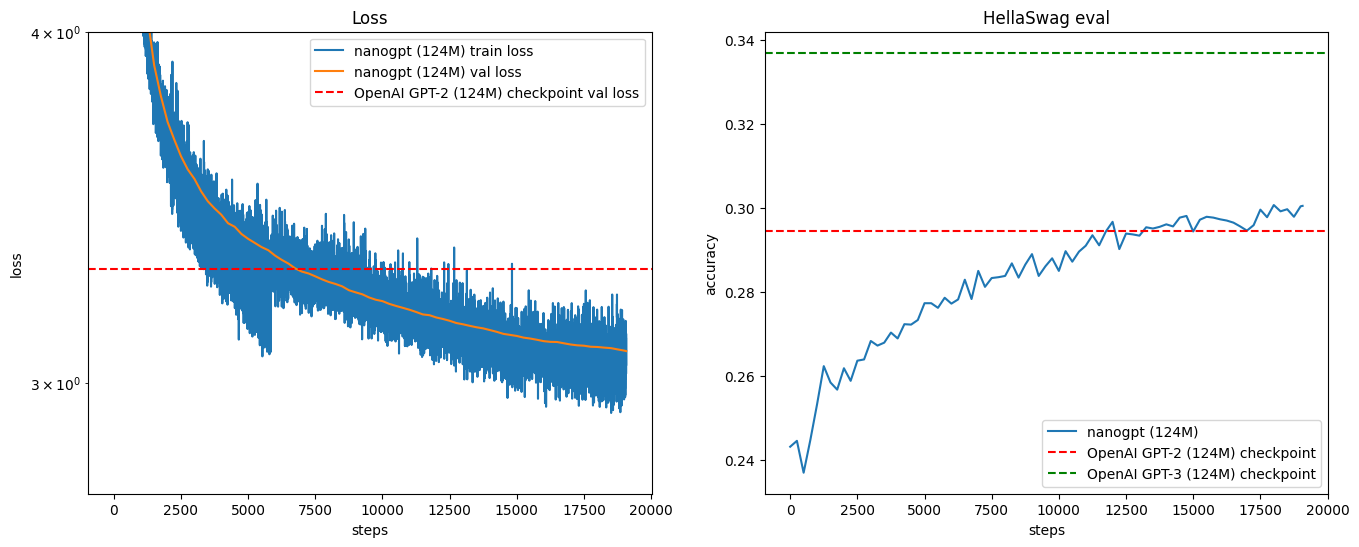

In [11]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("/Users/manpreet.singh/git/gpt/log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# List to store the formatted output
formatted_lines = []

# Iterate over each line
for line in lines:
    # Check if the line contains the step and val loss format
    if 'step:' in line and 'val loss:' in line:
        # Extract the step and val loss values
        step = line.split('step:')[1].split('|')[0].strip()
        val_loss = line.split('val loss:')[1].strip()
        # Append the formatted output
        formatted_lines.append(f"{step} val {val_loss}")
    else:
        # Append the line as it is (for other cases)
        formatted_lines.append(line.strip())

# Optional: If you want to save the formatted output back to a file
# with open('log_formatted_data.txt', 'w') as output_file:
#     for formatted_line in formatted_lines:
#         output_file.write(f"{formatted_line}\n")
    
# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in formatted_lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))
